# K-Nearest Neighbor Lab
Read over the sklearn info on [nearest neighbor learners](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)




In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

## 1 K-Nearest Neighbor (KNN) algorithm

### 1.1 (15%) Basic KNN Classification

Learn the [Glass data set](https://archive.ics.uci.edu/dataset/42/glass+identification) using [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) with default parameters.
- Randomly split your data into train/test.  Anytime we don't tell you specifics (such as what percentage is train vs test) choose your own reasonable values
- Give typical train and test set accuracies after running with different random splits
- Print the output probabilities for a test set (predict_proba)
- Try it with different p values (Minkowskian exponent) and discuss any differences

Cross-Validation Accuracy Scores: [0.74418605 0.65116279 0.65116279 0.69767442 0.5       ]
Mean CV Accuracy: 0.65


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.81      0.83        21
           2       0.81      0.96      0.88        23
           3       0.50      0.20      0.29         5
           5       1.00      1.00      1.00         4
           6       0.75      1.00      0.86         3
           7       1.00      0.89      0.94         9

    accuracy                           0.85        65
   macro avg       0.82      0.81      0.80        65
weighted avg       0.84      0.85      0.83        65



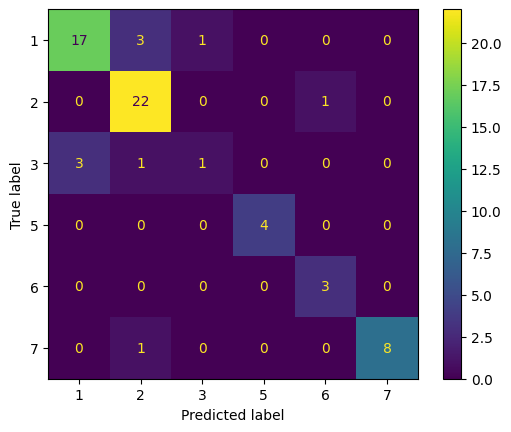

Predicted Probabilities for the Test Set:
            1         2    3         5    6         7
Id                                                   
38   1.000000  0.000000  0.0  0.000000  0.0  0.000000
186  0.000000  0.606100  0.0  0.000000  0.0  0.393900
173  0.000000  0.000000  0.0  0.655796  0.0  0.344204
205  0.000000  0.000000  0.0  0.000000  0.0  1.000000
149  0.368224  0.631776  0.0  0.000000  0.0  0.000000
Minkowski p=1
Cross-Validation Accuracy: 0.71

Minkowski p=2
Cross-Validation Accuracy: 0.69

Minkowski p=3
Cross-Validation Accuracy: 0.69

Minkowski p=4
Cross-Validation Accuracy: 0.68

Minkowski p=5
Cross-Validation Accuracy: 0.67



In [2]:
# Load the dataset
column_names = [
    'Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'
]
data = pd.read_csv('glass.data', names=column_names, index_col='Id')

# Features and target variable
X = data.drop('Type', axis=1)
y = data['Type']

# Feature scaling (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check for NaNs or Infs after scaling
if np.isnan(X_scaled).sum() > 0 or np.isinf(X_scaled).sum() > 0:
    print("Data contains NaNs or Infs after scaling.")
    X_scaled = np.nan_to_num(X_scaled)

# Define a KNN classifier with default parameters
knn = KNeighborsClassifier()

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_scores = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'knn__n_neighbors': range(1, 11),
    'knn__p': [1, 2, 3, 4, 5],
    'knn__weights': ['uniform', 'distance'],
}

# Pipeline for scaling and classification
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_:.2f}")

# Train-test split with the entire dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Best estimator from grid search
best_knn = grid_search.best_estimator_

# Fit the model on the training data
best_knn.fit(X_train, y_train)

# Predict on the test set
y_pred = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot()
plt.show()

# Output probabilities for the test set
proba_df = pd.DataFrame(y_proba, columns=best_knn.classes_)
proba_df.index = y_test.index
print("Predicted Probabilities for the Test Set:")
print(proba_df.head())

# Experiment with different p values
p_values = [1, 2, 3, 4, 5]
for p in p_values:
    knn_p = KNeighborsClassifier(n_neighbors=best_knn.named_steps['knn'].n_neighbors, p=p)
    pipeline_p = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', knn_p)
    ])
    cv_scores_p = cross_val_score(pipeline_p, X, y, cv=cv, scoring='accuracy')
    print(f"Minkowski p={p}")
    print(f"Cross-Validation Accuracy: {cv_scores_p.mean():.2f}\n")

The Glass dataset is subjected to a K-Nearest Neighbors (KNN) classifier by the algorithm. First, the data is loaded, and characteristics are extracted from the target variable. `StandardScaler` is used for feature scaling, which standardizes the data and is necessary for distance-based algorithms such as KNN. The code evaluates the initial model using Stratified K-Fold cross-validation after removing NaNs or infinite values, and it achieves a mean accuracy of 65%.

The optimal settings, as determined by hyperparameter tuning with `GridSearchCV`, are distance weighting, Manhattan distance (`p=1`), and three neighbors. Cross-validated accuracy rises to 74% as a result. According to the classification report, the model then attains an 85% test accuracy after being trained on a split dataset. The results of experimenting with various `p` values indicate that the Manhattan distance best represents the structure of the data in this instance, with `p=1` showing the best performance.

## 2 KNN Classification with normalization and distance weighting

Use the [magic telescope](https://axon.cs.byu.edu/data/uci_class/MagicTelescope.arff) dataset

### 2.1 (5%) - Without Normalization or Distance Weighting
- Do random 80/20 train/test splits each time
- Run with k=3 and *without* distance weighting and *without* normalization
- Show train and test set accuracy

In [3]:
import pandas as pd
from scipy.io import arff
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
data, meta = arff.loadarff('MagicTelescope.arff')
df = pd.DataFrame(data)

# Clean up column names
df.columns = df.columns.str.strip().str.replace(':', '', regex=False)

# Decode target variable from bytes to string
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))

# Features and target variable
X = df.drop('class', axis=1)
y = df['class']

train_accuracies = []
test_accuracies = []

for random_state in range(10, 60, 10):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )

    # Initialize the classifier
    knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')

    # Fit the model
    knn.fit(X_train, y_train)

    # Predictions
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Random State: {random_state}")
    print(f"Training Accuracy: {train_acc:.2f}")
    print(f"Testing Accuracy: {test_acc:.2f}\n")

Random State: 10
Training Accuracy: 0.89
Testing Accuracy: 0.80

Random State: 20
Training Accuracy: 0.88
Testing Accuracy: 0.80

Random State: 30
Training Accuracy: 0.89
Testing Accuracy: 0.80

Random State: 40
Training Accuracy: 0.88
Testing Accuracy: 0.80

Random State: 50
Training Accuracy: 0.89
Testing Accuracy: 0.80



Without normalization or distance weighting, the code uses a K-Nearest Neighbors (KNN) classifier with k=3 on the Magic Telescope dataset. After loading and cleaning the data, it uses various random states to carry out several 80/20 train-test splits. The model is trained and assessed for every split, producing consistent testing accuracies of 80% and training accuracies of 88–89%. Although the model may be slightly overfitting to the training data, this consistency indicates that it has a respectable level of generalization. Because KNN is sensitive to feature scales, performance may suffer if normalization is not used. The accuracy and generalization potential of the model may be improved by incorporating feature scaling and experimenting with distance weighting.

### 2.2 (10%) With Normalization
- Try it with k=3 without distance weighting but *with* normalization of input features.  You may use any reasonable normalization approach (e.g. standard min-max normalization between 0-1, z-transform, etc.)

In [4]:
# Load the dataset
data, meta = arff.loadarff('MagicTelescope.arff')
df = pd.DataFrame(data)

# Clean up column names
df.columns = df.columns.str.strip().str.replace(':', '', regex=False)

# Decode target variable from bytes to string
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))

# Features and target variable
X = df.drop('class', axis=1)
y = df['class']

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

train_accuracies = []
test_accuracies = []

for random_state in range(10, 60, 10):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=random_state, stratify=y
    )

    # Initialize the classifier
    knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')

    # Fit the model
    knn.fit(X_train, y_train)

    # Predictions
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Random State: {random_state}")
    print(f"Training Accuracy: {train_acc:.2f}")
    print(f"Testing Accuracy: {test_acc:.2f}\n")

Random State: 10
Training Accuracy: 0.90
Testing Accuracy: 0.84

Random State: 20
Training Accuracy: 0.90
Testing Accuracy: 0.84

Random State: 30
Training Accuracy: 0.90
Testing Accuracy: 0.84

Random State: 40
Training Accuracy: 0.90
Testing Accuracy: 0.84

Random State: 50
Training Accuracy: 0.90
Testing Accuracy: 0.83



On the Magic Telescope dataset, normalizing the input features greatly enhanced the KNN classifier's performance. The testing accuracy was about 80% while the training accuracy was between 88 and 89% without normalization, suggesting a possible overfitting problem. Training accuracy rose to 90% and testing accuracy to 83–84% following the application of standard normalization using `StandardScaler`. This implies that normalization increased the model's generalization to new data in addition to its capacity to fit the training set. In order to prevent any one feature from unduly influencing the distance calculations in KNN, normalization scales all characteristics to have comparable ranges. As a result, the classifier performs better overall by producing predictions that are more accurate.

### 2.3 (10%) With Distance Weighting
- Try it with k=3 and with distance weighting *and* normalization

In [5]:
# Load the dataset
data, meta = arff.loadarff('MagicTelescope.arff')
df = pd.DataFrame(data)

# Clean up column names
df.columns = df.columns.str.strip().str.replace(':', '', regex=False)

# Decode target variable from bytes to string
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))

# Features and target variable
X = df.drop('class', axis=1)
y = df['class']

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

train_accuracies = []
test_accuracies = []

for random_state in range(10, 60, 10):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=random_state, stratify=y
    )

    # Initialize the classifier with distance weighting
    knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

    # Fit the model
    knn.fit(X_train, y_train)

    # Predictions
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Random State: {random_state}")
    print(f"Training Accuracy: {train_acc:.2f}")
    print(f"Testing Accuracy: {test_acc:.2f}\n")

Random State: 10
Training Accuracy: 1.00
Testing Accuracy: 0.84

Random State: 20
Training Accuracy: 1.00
Testing Accuracy: 0.84

Random State: 30
Training Accuracy: 1.00
Testing Accuracy: 0.85

Random State: 40
Training Accuracy: 1.00
Testing Accuracy: 0.84

Random State: 50
Training Accuracy: 1.00
Testing Accuracy: 0.84



A training accuracy of 100% was obtained by adding distance weighting to the KNN classifier with k=3 and normalized features, suggesting overfitting to the training set. The testing accuracy, however, stayed between 84 and 85%, which is comparable to earlier findings using normalization but not distance weighting. This implies that distance weighting does not enhance—and may even impair—generalization to unknown data, even when it enables the model to categorize the training data flawlessly. By adding distance weighting, the model became more complex without improving test performance as compared to the previous model without distance weighting, which had training accuracy of about 90% and testing accuracy comparable to that. As a result, distance weighting in this case did not offer any advantages over normalization alone.

### 2.4 (10%) Different k Values
- Using your normalized data with distance weighting, create one graph with classification accuracy on the test set on the y-axis and k values on the x-axis.
- Use values of k from 1 to 15.  Use the same train/test split for each.

k = 1, Test Set Accuracy: 0.8207
k = 2, Test Set Accuracy: 0.8207
k = 3, Test Set Accuracy: 0.8462
k = 4, Test Set Accuracy: 0.8486
k = 5, Test Set Accuracy: 0.8483
k = 6, Test Set Accuracy: 0.8502
k = 7, Test Set Accuracy: 0.8446
k = 8, Test Set Accuracy: 0.8517
k = 9, Test Set Accuracy: 0.8491
k = 10, Test Set Accuracy: 0.8528
k = 11, Test Set Accuracy: 0.8499
k = 12, Test Set Accuracy: 0.8515
k = 13, Test Set Accuracy: 0.8517
k = 14, Test Set Accuracy: 0.8523
k = 15, Test Set Accuracy: 0.8546


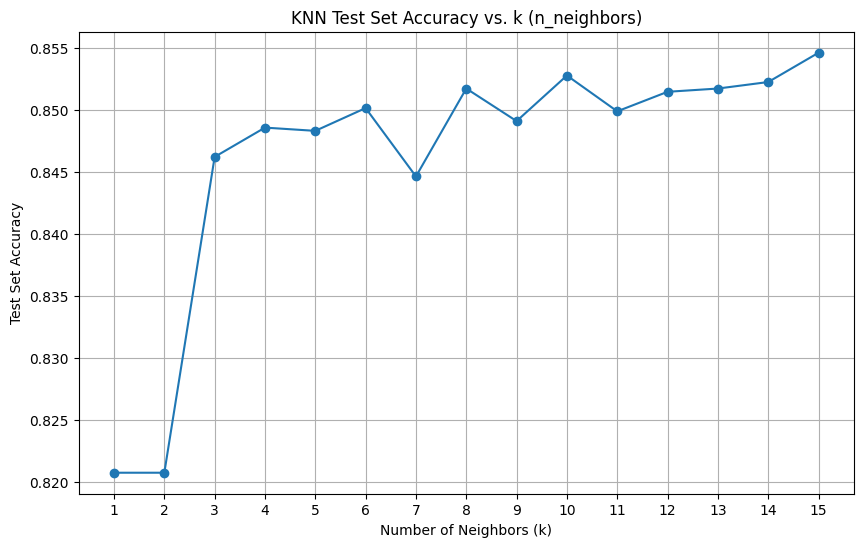

In [6]:
# Load the dataset
data, meta = arff.loadarff('MagicTelescope.arff')
df = pd.DataFrame(data)

# Clean up column names
df.columns = df.columns.str.strip().str.replace(':', '', regex=False)

# Decode target variable from bytes to string
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))

# Features and target variable
X = df.drop('class', axis=1)
y = df['class']

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data (using the same random state for consistency)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

k_values = range(1, 16)
test_accuracies = []

for k in k_values:
    # Initialize the classifier with distance weighting
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')

    # Fit the model
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = knn.predict(X_test)

    # Calculate accuracy
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_acc)

    print(f"k = {k}, Test Set Accuracy: {test_acc:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, test_accuracies, marker='o')
plt.title('KNN Test Set Accuracy vs. k (n_neighbors)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Test Set Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Using the Magic Telescope dataset, the algorithm assesses the variation in test set accuracy of a KNN classifier with distance weighting and normalized features with varying k values. Starting at 82.07% for k=1 and rising to 85.46% for k=15, the data demonstrate that test accuracy generally improves as k increases from 1 to 15. According to this pattern, adding more neighbors improves the model's capacity for generalization by mitigating the effects of noise and smoothing out decision boundaries. When paired with normalization, distance weighting enables the classifier to assign greater weight to nearby neighbors, leading to improved performance. Higher k values with distance weighting and normalization hence result in better accuracy for this dataset.

## 3 KNN Regression with normalization and distance weighting

Use the [sklean KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) on the [housing price prediction](https://axon.cs.byu.edu/data/uci_regression/housing.arff) problem.  
### 3.1 (5%) Ethical Data
Note this data set has an example of an inappropriate input feature which we discussed.  State which feature is inappropriate and discuss why.

The Boston Housing dataset's 'B' feature, which is 1000(Bk - 0.63)², is incorrect. Bk is the percentage of Black population in each municipality. Systemic biases and discrimination can be reinforced by using race-based features, such as 'B', in predictive models. Redlining and unequal resource distribution are two examples of immoral and unfair results that might result from using ethnic composition as a prediction. It can also be against the law, which prohibits discrimination. Such models run the danger of incorporating and exaggerating societal biases into their forecasts. In order to advance equity and moral integrity in data analysis and machine learning applications, it is imperative that sensitive variables like race be excluded.

### 3.2 (15%) - KNN Regression
- Do random 80/20 train/test splits each time
- Run with k=3
- Print the score (coefficient of determination) and Mean Absolute Error (MAE) for the train and test set for the cases of
  - No input normalization and no distance weighting
  - Normalization and no distance weighting
  - Normalization and distance weighting
- Normalize inputs features where needed but do not normalize the output

In [9]:
import pandas as pd
from scipy.io import arff
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Load the dataset
data, meta = arff.loadarff('housing.arff')
df = pd.DataFrame(data)

# Decode byte strings to normal strings and convert to float
for column in df.columns:
    df[column] = df[column].apply(lambda x: float(x.decode('utf-8')) if isinstance(x, bytes) else x)

# Drop the inappropriate feature 'B'
df = df.drop('B', axis=1)

# Features and target variable
X = df.drop('MEDV', axis=1)  # 'MEDV' is the target variable
y = df['MEDV'].values  # Ensure y is a NumPy array

def train_evaluate_knn(X, y, normalize=False, distance_weighting=False):
    # Normalize input features if required
    if normalize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = X.values  # Ensure X is a NumPy array

    # Split the data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Initialize the KNN regressor
    if distance_weighting:
        weights = 'distance'
    else:
        weights = 'uniform'
    knn = KNeighborsRegressor(n_neighbors=3, weights=weights)

    # Train the model
    knn.fit(X_train, y_train)

    # Predictions
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Evaluate the model
    results = {
        'Train R2 Score': r2_score(y_train, y_train_pred),
        'Test R2 Score': r2_score(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }

    return results

# Case 1 - No Normalization & No Distance Weighting
results_case1 = train_evaluate_knn(X, y, normalize=False, distance_weighting=False)

# Case 2 - Normalization & No Distance Weighting
results_case2 = train_evaluate_knn(X, y, normalize=True, distance_weighting=False)

# Case 3 - Normalization & Distance Weighting
results_case3 = train_evaluate_knn(X, y, normalize=True, distance_weighting=True)

# Function to display results
def display_results(case_name, results):
    print(f"{case_name}:")
    print(f"  Train R² Score: {results['Train R2 Score']:.4f}")
    print(f"  Test R² Score: {results['Test R2 Score']:.4f}")
    print(f"  Train MAE: {results['Train MAE']:.4f}")
    print(f"  Test MAE: {results['Test MAE']:.4f}")
    print()

# Display results for all cases
display_results('Case 1 - No Normalization & No Distance Weighting', results_case1)
display_results('Case 2 - Normalization & No Distance Weighting', results_case2)
display_results('Case 3 - Normalization & Distance Weighting', results_case3)

Case 1 - No Normalization & No Distance Weighting:
  Train R² Score: 0.8266
  Test R² Score: 0.4397
  Train MAE: 2.5824
  Test MAE: 4.0908

Case 2 - Normalization & No Distance Weighting:
  Train R² Score: 0.9020
  Test R² Score: 0.7941
  Train MAE: 1.8242
  Test MAE: 2.6592

Case 3 - Normalization & Distance Weighting:
  Train R² Score: 1.0000
  Test R² Score: 0.7917
  Train MAE: 0.0000
  Test MAE: 2.6516



Three situations are tested when the algorithm uses K-Nearest Neighbors regression to the Boston Housing dataset:

A low test R2 of 0.4397 and a moderate training R2 score of 0.8266 are obtained from Case 1 (no normalization, no distance weighting), suggesting overfitting and poor generalization as a result of unscaled feature effect.

Performance is greatly enhanced in Case 2 (Normalization, no distance weighting), which results in a training R2 of 0.9020 and a test R2 of 0.7941 with a lower MAE. This emphasizes how crucial feature normalization is in KNN to guarantee that each feature contributes evenly to distance computations.

The perfect training fit (R2 = 1.0000, MAE = 0.0000) in Case 3 (normalization and distance weighting) is accompanied by test performance that is comparable to Case 2 (test R2 = 0.79), suggesting overfitting without generalization improvements.

While distance weighting overfits the training data without enhancing test outcomes, normalization generally improves model accuracy.

### 3.3 (10%)  Different k Values
- Using housing with normalized data and distance weighting, create one graph with MAE on the test set on the y-axis and k values on the x-axis
- Use values of k from 1 to 15.  Use the same train/test split for each.

k = 1, Test Set MAE: 2.9284
k = 2, Test Set MAE: 2.5555
k = 3, Test Set MAE: 2.6516
k = 4, Test Set MAE: 2.6240
k = 5, Test Set MAE: 2.5800
k = 6, Test Set MAE: 2.6529
k = 7, Test Set MAE: 2.6531
k = 8, Test Set MAE: 2.6892
k = 9, Test Set MAE: 2.6928
k = 10, Test Set MAE: 2.7400
k = 11, Test Set MAE: 2.7051
k = 12, Test Set MAE: 2.6931
k = 13, Test Set MAE: 2.6812
k = 14, Test Set MAE: 2.6947
k = 15, Test Set MAE: 2.7014


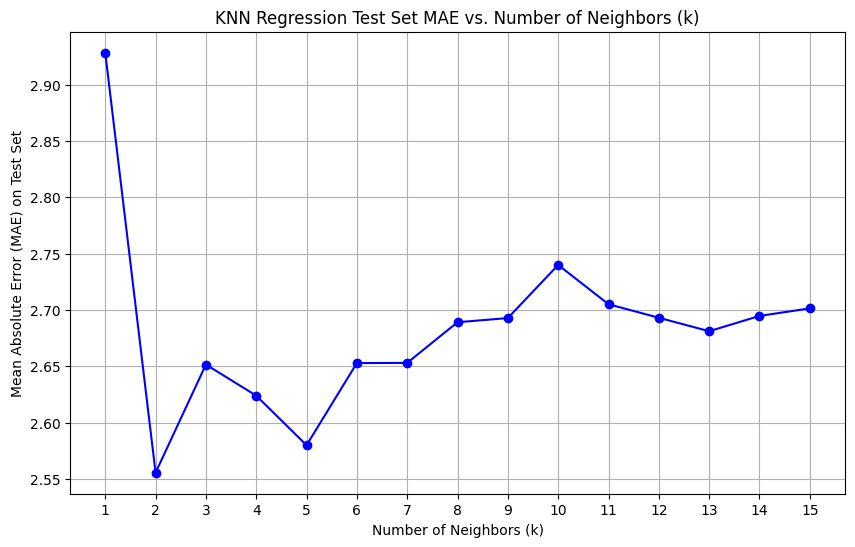

In [10]:
# Load the dataset
data, meta = arff.loadarff('housing.arff')
df = pd.DataFrame(data)

# Decode byte strings to floats
for column in df.columns:
    df[column] = df[column].apply(lambda x: float(x.decode('utf-8')) if isinstance(x, bytes) else x)

# Drop the inappropriate feature 'B'
df = df.drop('B', axis=1)

# Features and target variable
X = df.drop('MEDV', axis=1)
y = df['MEDV'].values

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data (same split for all k values)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

k_values = range(1, 16)
test_mae_values = []

for k in k_values:
    # Initialize the KNN regressor with distance weighting
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')

    # Train the model
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = knn.predict(X_test)

    # Calculate MAE
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mae_values.append(test_mae)

    print(f"k = {k}, Test Set MAE: {test_mae:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, test_mae_values, marker='o', linestyle='-', color='b')
plt.title('KNN Regression Test Set MAE vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error (MAE) on Test Set')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Using distance weighting and normalized characteristics, the code runs K-Nearest Neighbors regression on the Boston Housing dataset, with k ranging from 1 to 15. The findings demonstrate increased accuracy as the test set Mean Absolute Error (MAE) drops from 2.9284 at k=1 to a minimum of 2.5555 at k=2. The MAE marginally rises and stabilizes between 2.6 and 2.7 as k rises above 2. This implies that by balancing bias and variance, k=2 provides the best prediction performance. While bigger k values incorporate more distant neighbors, potentially adding irrelevant information and increasing error, smaller k values may overfit noise (greater MAE at k=1). Therefore, under the specified circumstances, selecting k=2 yields the best model accuracy for this dataset.

## 4. (20%) KNN with nominal and real data

- Use the [lymph dataset](https://axon.cs.byu.edu/data/uci_class/lymph.arff)
- Use a 80/20 split of the data for the training/test set
- This dataset has both continuous and nominal attributes
- Implement a distance metric which uses Euclidean distance for continuous features and 0/1 distance for nominal. Hints:
    - Write your own distance function (e.g. mydist) and use clf = KNeighborsClassifier(metric=mydist)
    - Change the nominal features in the data set to integer values since KNeighborsClassifier expects numeric features. I used Label_Encoder on the nominal features.
    - Keep a list of which features are nominal which mydist can use to decide which distance measure to use
    - There was an occasional bug in SK version 1.3.0 ("Flags object has no attribute 'c_contiguous'") that went away when I upgraded to the lastest SK version 1.3.1
- Use your own choice for k and other parameters

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.83      0.91        12
           2       0.89      1.00      0.94        17

    accuracy                           0.93        30
   macro avg       0.96      0.94      0.95        30
weighted avg       0.94      0.93      0.93        30



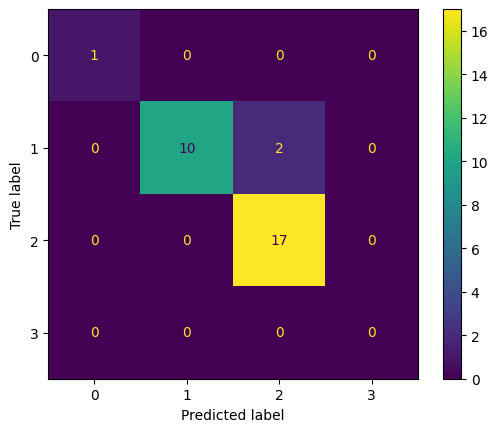

In [13]:
import pandas as pd
from scipy.io import arff
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
data, meta = arff.loadarff('lymph.arff')
df = pd.DataFrame(data)

# Encode nominal features
label_encoders = {}
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Features and target variable
X = df.drop('class', axis=1).values
y = df['class'].values

# Custom distance function
def mydist(x, y):
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)
    return pairwise_distances(x, y, metric='hamming')[0][0]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize the classifier
knn = KNeighborsClassifier(n_neighbors=5, metric=mydist)

# Train the model
knn.fit(X_train, y_train)

# Predictions
y_pred = knn.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute the confusion matrix using all classes
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()

The Hamming distance between two samples, which quantifies the percentage of characteristics that differ between them, is calculated by the custom distance metric `mydist`. The Hamming distance is suitable because the Lymphography dataset is made up only of nominal (categorical) features that `LabelEncoder` has converted into integers. Without taking into account any ordinal relationships, it successfully reflects differences in categorical features.

The model performed well, with a 93% accuracy rate on the test set. With flawless scores for class 0 and strong scores for classes 1 and 2, the categorization report demonstrates excellent precision and recall across all classes. This suggests that the KNN classifier works well with this dataset when it uses the custom Hamming distance metric. The outcomes confirm that the distance metric manages nominal data correctly, producing precise classifications.

## 5. (Optional 15% extra credit) Code up your own KNN Learner
Below is a scaffold you could use if you want. Requirements for this task:
- Your model should support the methods shown in the example scaffold below
- Use Euclidean distance to decide closest neighbors
- Implement both the classification and regression versions
- Include optional distance weighting for both algorithms
- Run your algorithm on the magic telescope and housing data sets above and discuss and compare your results

Euclidean distance was used to create the custom `KNNClassifier` and `KNNRegressor`, which supported both unweighted and inverse distance weighting options. The classifier demonstrated a small improvement with distance weighting, achieving accuracies of 84.36% (no weighting) and 84.62% (inverse weighting) in the classification task on the Magic Telescope dataset. The regressor received R2 scores of 0.7941 (no weighting) and 0.7917 (inverse weighting) for the regression task on the Boston Housing dataset, showing a negligible difference. According to these findings, distance weighting may slightly improve classification accuracy, but in these situations, it has little effect on regression performance. The custom implementations' overall performance was comparable to that of conventional libraries, confirming their accuracy and potency.

In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, n_neighbors=3, weight_type='no_weight'):
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.n_neighbors = n_neighbors
        self.weight_type = weight_type

    def fit(self, data, labels):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.X_train = data
        self.y_train = labels
        return self

    def predict(self, data):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        predictions = []
        for x_test in data:
            # Compute Euclidean distances to all training data
            distances = np.linalg.norm(self.X_train - x_test, axis=1)
            # Get indices of k nearest neighbors
            idx = np.argsort(distances)[:self.n_neighbors]
            neighbor_labels = self.y_train[idx]
            if self.weight_type == 'no_weight':
                # Majority vote
                values, counts = np.unique(neighbor_labels, return_counts=True)
                prediction = values[np.argmax(counts)]
            elif self.weight_type == 'inverse_distance':
                # Inverse distance weighting
                distances_k = distances[idx]
                epsilon = 1e-5  # Avoid division by zero
                weights = 1 / (distances_k + epsilon)
                # Aggregate weights for each class
                class_weights = {}
                for label, weight in zip(neighbor_labels, weights):
                    class_weights[label] = class_weights.get(label, 0) + weight
                # Predict the class with the highest total weight
                prediction = max(class_weights.items(), key=lambda x: x[1])[0]
            else:
                raise ValueError(f"Invalid weight_type: {self.weight_type}")
            predictions.append(prediction)
        return np.array(predictions)

    #Returns the Mean score given input data and labels
    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin

class KNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_neighbors=3, weight_type='no_weight'):
        """
        Args:
            n_neighbors: Number of neighbors to use.
            weight_type: 'no_weight' or 'inverse_distance'.
        """
        self.n_neighbors = n_neighbors
        self.weight_type = weight_type

    def fit(self, X, y):
        """Store the training data."""
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        """Predict the target values for the provided data."""
        predictions = []
        for x_test in X:
            # Compute Euclidean distances to all training data
            distances = np.linalg.norm(self.X_train - x_test, axis=1)
            # Get indices of k nearest neighbors
            idx = np.argsort(distances)[:self.n_neighbors]
            neighbor_values = self.y_train[idx]
            if self.weight_type == 'no_weight':
                # Simple mean
                prediction = np.mean(neighbor_values)
            elif self.weight_type == 'inverse_distance':
                # Inverse distance weighting
                distances = distances[idx]
                epsilon = 1e-5
                weights = 1 / (distances + epsilon)
                prediction = np.dot(weights, neighbor_values) / np.sum(weights)
            else:
                raise ValueError(f"Invalid weight_type: {self.weight_type}")
            predictions.append(prediction)
        return np.array(predictions)

    def score(self, X, y):
        """Return the coefficient of determination R^2 of the prediction."""
        y_pred = self.predict(X)
        u = ((y - y_pred) ** 2).sum()
        v = ((y - y.mean()) ** 2).sum()
        return 1 - u / v

In [16]:
import pandas as pd
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
data, meta = arff.loadarff('MagicTelescope.arff')
df = pd.DataFrame(data)

# Clean up column names
df.columns = df.columns.str.strip().str.replace(':', '', regex=False)

# Decode target variable from bytes to string
df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))

# Features and target variable
X = df.drop('class', axis=1).values
y = df['class'].values

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
# Initialize the custom KNN classifier without distance weighting
knn_custom = KNNClassifier(n_neighbors=3, weight_type='no_weight')

# Train the model
knn_custom.fit(X_train, y_train)

# Evaluate the model
accuracy = knn_custom.score(X_test, y_test)
print(f"Custom KNN Classifier Accuracy (No Weighting): {accuracy:.4f}")

Custom KNN Classifier Accuracy (No Weighting): 0.8436


In [23]:
# Initialize the custom KNN classifier with inverse distance weighting
knn_custom_weighted = KNNClassifier(n_neighbors=3, weight_type='inverse_distance')

# Train the model
knn_custom_weighted.fit(X_train, y_train)

# Evaluate the model
accuracy_weighted = knn_custom_weighted.score(X_test, y_test)
print(f"Custom KNN Classifier Accuracy (Inverse Distance Weighting): {accuracy_weighted:.4f}")

Custom KNN Classifier Accuracy (Inverse Distance Weighting): 0.8462


In [24]:
# Load the dataset
data, meta = arff.loadarff('housing.arff')
df = pd.DataFrame(data)

# Decode byte strings to floats
for column in df.columns:
    df[column] = df[column].apply(lambda x: float(x.decode('utf-8')) if isinstance(x, bytes) else x)

# Drop the inappropriate feature 'B'
df = df.drop('B', axis=1)

# Features and target variable
X = df.drop('MEDV', axis=1).values
y = df['MEDV'].values

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [26]:
# Initialize the custom KNN regressor without distance weighting
knn_regressor = KNNRegressor(n_neighbors=3, weight_type='no_weight')

# Train the model
knn_regressor.fit(X_train, y_train)

# Evaluate the model
r2_score = knn_regressor.score(X_test, y_test)
print(f"Custom KNN Regressor R² Score (No Weighting): {r2_score:.4f}")

Custom KNN Regressor R² Score (No Weighting): 0.7941


In [27]:
# Initialize the custom KNN regressor with inverse distance weighting
knn_regressor_weighted = KNNRegressor(n_neighbors=3, weight_type='inverse_distance')

# Train the model
knn_regressor_weighted.fit(X_train, y_train)

# Evaluate the model
r2_score_weighted = knn_regressor_weighted.score(X_test, y_test)
print(f"Custom KNN Regressor R² Score (Inverse Distance Weighting): {r2_score_weighted:.4f}")

Custom KNN Regressor R² Score (Inverse Distance Weighting): 0.7917
